## Regressão logística

### Bibliotecas e bases de dados

In [9]:
from IPython.display import HTML, display_html
import warnings
import pandas as pd

# from imblearn.over_sampling import SMOTE
from skopt import BayesSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold

# from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import (
    classification_report,
    make_scorer,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay,
    confusion_matrix
)

from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.exceptions import ConvergenceWarning

#Estilizar conteúdo
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=ConvergenceWarning)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

def estilo_tabelas(df, max_altura='300px', casas_decimais=3):
    return (
        df.style.set_table_styles(
            [
                {'selector': 'thead th', 'props': [('font-size', '12px'), ('text-align', 'center'), ('border-bottom', '2px solid #007BFF')]},
                {'selector': 'td', 'props': [('font-size', '10px'), ('text-align', 'center'), ('max-height', '40px'), ('white-space', 'nowrap'), ('text-overflow', 'ellipsis'), ('overflow', 'hidden'), ('max-width', '100px')]},
                {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]},
                {'selector': 'table', 'props': [('width', '90%'), ('margin-left', 'auto'), ('margin-right', 'auto'), ('border-collapse', 'collapse')]},
                {'selector': 'td, th', 'props': [('border', '1px solid #666')]},  # Bordas cinza escuro
            ]
        ).set_properties(
            **{'border-color': 'darkgray', 'border-style': 'solid', 'border-width': '1px'}
        ).set_table_attributes(
            f'style="height:auto; overflow:auto; max-height:{max_altura}; display:block;"'  
        ).format(
            precision=casas_decimais  
        )
    )

df1 = pd.read_csv(
    "https://raw.githubusercontent.com/brunagmoura/PrevisorReconhecimento/refs/heads/main/df_eventos_2010_2017_modelo1.csv",
    sep=';',
    decimal=',',
)

df2 = pd.read_csv(
    "https://raw.githubusercontent.com/brunagmoura/PrevisorReconhecimento/refs/heads/main/df_eventos_2010_2017_modelo2.csv",
    sep=';',
    decimal=',',
)

df3 = pd.read_csv(
    "https://raw.githubusercontent.com/brunagmoura/PrevisorReconhecimento/refs/heads/main/df_eventos_2018_2024_modelo1.csv",
    sep=';',
    decimal=',',
)

df4 = pd.read_csv(
    "https://raw.githubusercontent.com/brunagmoura/PrevisorReconhecimento/refs/heads/main/df_eventos_2018_2024_modelo2.csv",
    sep=';',
    decimal=',',
)

### Ajustes das bases de dados

In [10]:
# Remove nulos
df2 = df2[df2['DensidadePop'].notnull()]
df4 = df4[df4['DensidadePop'].notnull()]
df3 = df3[df3['DOMICILIO_AREARURAL'].notnull()]
df4 = df4[df4['DOMICILIO_AREARURAL'].notnull()]

# Criar dicionário python com uma descrição para cada conjunto de dados
dict_dfs = {
    "Modelo 1 - 2010 a 2017 - reduzido": df1,
    "Modelo 2 - 2010 a 2017 - estendido": df2,
    "Modelo 3 - 2018 a 2024 - reduzido": df3,
    "Modelo 4 - 2018 a 2024 - estendido": df4,
}

print("Dimensão da base de dados 1: ", df1.shape)
print("Dimensão da base de dados 2: ", df2.shape)
print("Dimensão da base de dados 3: ", df3.shape)
print("Dimensão da base de dados 4: ", df4.shape)

Dimensão da base de dados 1:  (13047, 56)
Dimensão da base de dados 2:  (8600, 117)
Dimensão da base de dados 3:  (13170, 61)
Dimensão da base de dados 4:  (8275, 122)


### Treino e teste

#### Modelo base

In [11]:
def exibe_matrizes_confusao(dicio_matrizes):
    fig, axn = plt.subplots(1, 4,  sharey=True, figsize=(10, 2))
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.5)
    for i, ax in enumerate(axn.flat):
        k = list(dicio_matrizes)[i]

        ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45,fontsize=8)
        ax.set_title(k,fontsize=8)

        sns.heatmap(dicio_matrizes[k], ax=ax,cbar=i==4)
        sns.heatmap(dicio_matrizes[k], annot=True, fmt="d", cmap="Blues", ax=ax, cbar=i==4,
                xticklabels=['Não Reconhecido', 'Reconhecido'],
                yticklabels=['Não Reconhecido', 'Reconhecido'],)

,Não reconhecido,Reconhecido,accuracy,macro avg,weighted avg
precision,0.262069,0.931897,0.857471,0.596983,0.871843
recall,0.324786,0.909933,0.857471,0.617359,0.857471
f1-score,0.290076,0.920784,0.857471,0.605430,0.864237
support,234.000000,2376.000000,0.857471,2610.000000,2610.000000
,Não reconhecido,Reconhecido,accuracy,macro avg,weighted avg
precision,0.155963,0.921167,0.872674,0.538565,0.857103
recall,0.118056,0.941624,0.872674,0.529840,0.872674
f1-score,0.134387,0.931283,0.872674,0.532835,0.864566
support,144.000000,1576.000000,0.872674,1720.000000,1720.000000
,Não reconhecido,Reconhecido,accuracy,macro avg,weighted avg


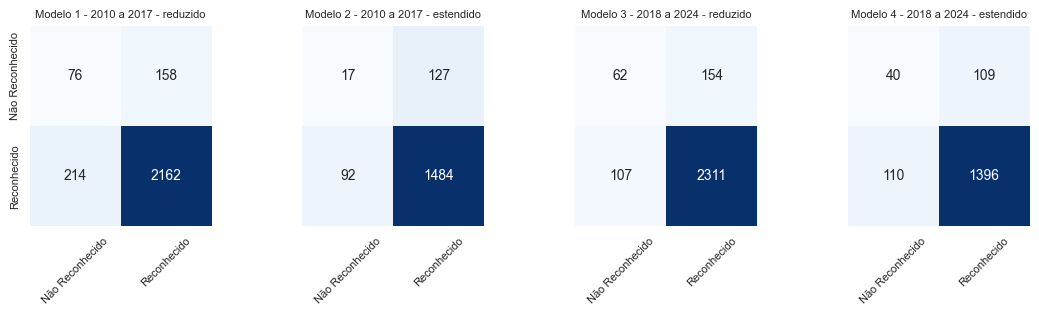

In [12]:
classification_report_html = ""
cf_matrix = dict.fromkeys(dict_dfs.keys())

for desc_modelo, df in dict_dfs.items():

    # Separa treino/teste
    X = df.drop("Status", axis=1)
    y = df["Status"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Pipeline
    pipeline = Pipeline(
        steps=[
            ("robust_scaler", RobustScaler()),
            ("log_reg", LogisticRegression(max_iter=1000, random_state=42, solver="liblinear", class_weight={0: 5, 1: 1}, )),
        ]
    )
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Classification report
    df_cr = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True, target_names=["Não reconhecido", "Reconhecido"]))
    df_cr = df_cr.style.set_table_attributes("style='display:inline'").set_caption(desc_modelo)
    classification_report_html += df_cr._repr_html_()

    # Confusion Matrix
    cf_matrix[desc_modelo]=confusion_matrix(y_test, y_pred)

# Classification report
display_html(classification_report_html, raw=True)

# Confusion Matrix
exibe_matrizes_confusao(cf_matrix)

#### Modelos com hiperparâmetros - **CV - 3**

In [ ]:
classification_report_html = ""
cf_matrix = dict.fromkeys(dict_dfs.keys())

for desc_modelo, df in dict_dfs.items():

    # Separa treino/teste
    X = df.drop("Status", axis=1)
    y = df["Status"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    # Pipeline
    pipeline = Pipeline(
        steps=[
            ("robust_scaler", RobustScaler()),
            ("log_reg", LogisticRegression(max_iter=1000, random_state=42, solver="liblinear")),
        ]
    )
    # Hiperparâmetros
    param_grid = {
        "log_reg__class_weight": ['balanced', {0: 5, 1: 1}, {0: 10, 1: 1}],
        "log_reg__C": [0.01, 0.1, 1, 10, 100],
        "log_reg__penalty": ["l2", "l1"],
        "log_reg__fit_intercept": [True, False],
        "log_reg__tol": [1e-4, 1e-3],
        #'log_reg__solver': ['liblinear', 'saga']
    }

    """ Não funcionou para a classe 'Não reconhecido'. Acertou 0.00
    scorer = make_scorer(recall_score)
    # Realiza a busca bayesiana com validação cruzada
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    #BayesSearchCV
    bayers_search = BayesSearchCV(
        pipeline,
        search_spaces=param_grid,
        scoring="f1",
        cv=cv,
        n_jobs=-1,
        random_state=42,
    )
    bayers_search.fit(X_train, y_train)
    best_logreg_model = bayers_search.best_estimator_
    """

    #GridSearchCV
    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring="f1",
        cv=3,
        n_jobs=-1,
    )
    grid_search.fit(X_train, y_train)
    best_logreg_model = grid_search.best_estimator_

    # Exibir os melhores hiperparâmetros
    print(f"Melhores hiperparâmetros: {grid_search.best_params_}")

    # Previsões no conjunto de teste
    y_pred_tuned = best_logreg_model.predict(X_test)

     # Classification report
    df_cr = pd.DataFrame(classification_report(y_test, y_pred_tuned, output_dict=True, target_names=["Não reconhecido", "Reconhecido"]))
    df_cr = df_cr.style.set_table_attributes("style='display:inline'").set_caption(desc_modelo)
    classification_report_html += df_cr._repr_html_()

    # Confusion Matrix
    cf_matrix[desc_modelo]=confusion_matrix(y_test, y_pred_tuned)

# Classification report
display_html(classification_report_html, raw=True)

# Confusion Matrix
exibe_matrizes_confusao(cf_matrix)



Melhores hiperparâmetros: {'log_reg__C': 0.01, 'log_reg__class_weight': {0: 5, 1: 1}, 'log_reg__fit_intercept': True, 'log_reg__penalty': 'l1', 'log_reg__tol': 0.0001}


/Users/brunamoura/PrevisorReconhecimento/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/brunamoura/PrevisorReconhecimento/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/brunamoura/PrevisorReconhecimento/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/brunamoura/PrevisorReconhecimento/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/brunamoura/PrevisorReconhecimento/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iter

#### Modelos com hiperparâmetros - **CV - 5**

Melhores hiperparâmetros: {'log_reg__C': 0.01, 'log_reg__class_weight': {0: 5, 1: 1}, 'log_reg__fit_intercept': True, 'log_reg__penalty': 'l1', 'log_reg__tol': 0.001}
Melhores hiperparâmetros: {'log_reg__C': 0.01, 'log_reg__class_weight': {0: 5, 1: 1}, 'log_reg__fit_intercept': True, 'log_reg__penalty': 'l1', 'log_reg__tol': 0.0001}
Melhores hiperparâmetros: {'log_reg__C': 1, 'log_reg__class_weight': {0: 5, 1: 1}, 'log_reg__fit_intercept': False, 'log_reg__penalty': 'l2', 'log_reg__tol': 0.0001}
Melhores hiperparâmetros: {'log_reg__C': 0.01, 'log_reg__class_weight': {0: 5, 1: 1}, 'log_reg__fit_intercept': True, 'log_reg__penalty': 'l1', 'log_reg__tol': 0.0001}


,Não reconhecido,Reconhecido,accuracy,macro avg,weighted avg
precision,0.292793,0.929229,0.875096,0.611011,0.872170
recall,0.277778,0.933923,0.875096,0.605850,0.875096
f1-score,0.285088,0.931570,0.875096,0.608329,0.873610
support,234.000000,2376.000000,0.875096,2610.000000,2610.000000
,Não reconhecido,Reconhecido,accuracy,macro avg,weighted avg
precision,0.184783,0.921990,0.882558,0.553386,0.860270
recall,0.118056,0.952411,0.882558,0.535233,0.882558
f1-score,0.144068,0.936954,0.882558,0.540511,0.870573
support,144.000000,1576.000000,0.882558,1720.000000,1720.000000
,Não reconhecido,Reconhecido,accuracy,macro avg,weighted avg


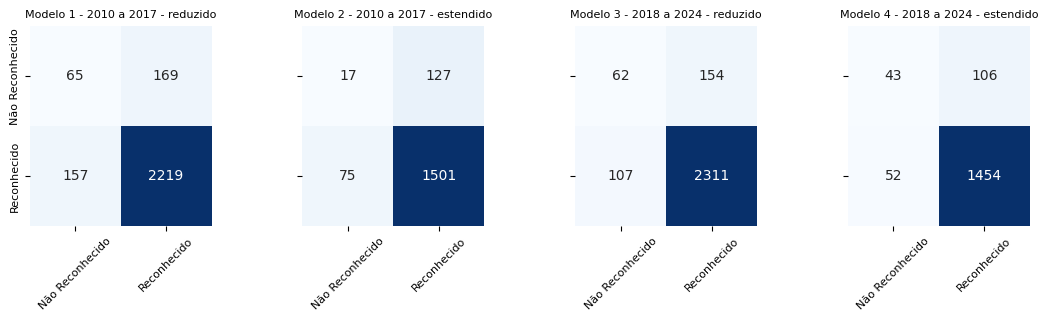

In [ ]:

classification_report_html = ""
cf_matrix = dict.fromkeys(dict_dfs.keys())

for desc_modelo, df in dict_dfs.items():

    # Separa treino/teste
    X = df.drop("Status", axis=1)
    y = df["Status"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    # Pipeline
    pipeline = Pipeline(
        steps=[
            ("robust_scaler", RobustScaler()),
            ("log_reg", LogisticRegression(max_iter=1000, random_state=42, solver="liblinear")),
        ]
    )
    # Hiperparâmetros
    param_grid = {
        "log_reg__class_weight": ['balanced', {0: 5, 1: 1}, {0: 10, 1: 1}],
        "log_reg__C": [0.01, 0.1, 1, 10, 100],
        "log_reg__penalty": ["l2", "l1"],
        "log_reg__fit_intercept": [True, False],
        "log_reg__tol": [1e-4, 1e-3],
        #'log_reg__solver': ['liblinear', 'saga']
    }

    #GridSearchCV
    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring="f1",
        cv=5,
        n_jobs=-1,
    )
    grid_search.fit(X_train, y_train)
    best_logreg_model = grid_search.best_estimator_

    # Exibir os melhores hiperparâmetros
    print(f"Melhores hiperparâmetros: {grid_search.best_params_}")

    # Previsões no conjunto de teste
    y_pred_tuned = best_logreg_model.predict(X_test)

     # Classification report
    df_cr = pd.DataFrame(classification_report(y_test, y_pred_tuned, output_dict=True, target_names=["Não reconhecido", "Reconhecido"]))
    df_cr = df_cr.style.set_table_attributes("style='display:inline'").set_caption(desc_modelo)
    classification_report_html += df_cr._repr_html_()

    # Confusion Matrix
    cf_matrix[desc_modelo]=confusion_matrix(y_test, y_pred_tuned)

# Classification report
display_html(classification_report_html, raw=True)

# Confusion Matrix
exibe_matrizes_confusao(cf_matrix)



#### Modelos com hiperparâmetros - **CV - 10**


Melhores hiperparâmetros: {'log_reg__C': 0.01, 'log_reg__class_weight': {0: 5, 1: 1}, 'log_reg__fit_intercept': True, 'log_reg__penalty': 'l1', 'log_reg__tol': 0.0001}
Melhores hiperparâmetros: {'log_reg__C': 0.01, 'log_reg__class_weight': {0: 5, 1: 1}, 'log_reg__fit_intercept': True, 'log_reg__penalty': 'l1', 'log_reg__tol': 0.001}
Melhores hiperparâmetros: {'log_reg__C': 100, 'log_reg__class_weight': {0: 5, 1: 1}, 'log_reg__fit_intercept': True, 'log_reg__penalty': 'l2', 'log_reg__tol': 0.001}
Melhores hiperparâmetros: {'log_reg__C': 0.01, 'log_reg__class_weight': {0: 5, 1: 1}, 'log_reg__fit_intercept': True, 'log_reg__penalty': 'l1', 'log_reg__tol': 0.0001}


,Não reconhecido,Reconhecido,accuracy,macro avg,weighted avg
precision,0.289593,0.928841,0.874713,0.609217,0.871529
recall,0.273504,0.933923,0.874713,0.603713,0.874713
f1-score,0.281319,0.931375,0.874713,0.606347,0.873094
support,234.000000,2376.000000,0.874713,2610.000000,2610.000000
,Não reconhecido,Reconhecido,accuracy,macro avg,weighted avg
precision,0.184783,0.921990,0.882558,0.553386,0.860270
recall,0.118056,0.952411,0.882558,0.535233,0.882558
f1-score,0.144068,0.936954,0.882558,0.540511,0.870573
support,144.000000,1576.000000,0.882558,1720.000000,1720.000000
,Não reconhecido,Reconhecido,accuracy,macro avg,weighted avg


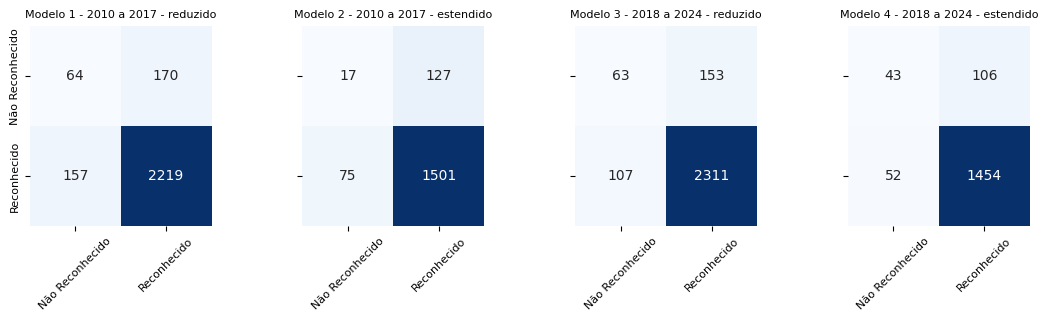

In [ ]:
classification_report_html = ""
cf_matrix = dict.fromkeys(dict_dfs.keys())

for desc_modelo, df in dict_dfs.items():

    # Separa treino/teste
    X = df.drop("Status", axis=1)
    y = df["Status"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    # Pipeline
    pipeline = Pipeline(
        steps=[
            ("robust_scaler", RobustScaler()),
            ("log_reg", LogisticRegression(max_iter=1000, random_state=42, solver="liblinear")),
        ]
    )
    # Hiperparâmetros
    param_grid = {
        "log_reg__class_weight": ['balanced', {0: 5, 1: 1}, {0: 10, 1: 1}],
        "log_reg__C": [0.01, 0.1, 1, 10, 100],
        "log_reg__penalty": ["l2", "l1"],
        "log_reg__fit_intercept": [True, False],
        "log_reg__tol": [1e-4, 1e-3],
        #'log_reg__solver': ['liblinear', 'saga']
    }

    #GridSearchCV
    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring="f1",
        cv=10,
        n_jobs=-1,
    )
    grid_search.fit(X_train, y_train)
    best_logreg_model = grid_search.best_estimator_

    # Exibir os melhores hiperparâmetros
    print(f"Melhores hiperparâmetros: {grid_search.best_params_}")

    # Previsões no conjunto de teste
    y_pred_tuned = best_logreg_model.predict(X_test)

     # Classification report
    df_cr = pd.DataFrame(classification_report(y_test, y_pred_tuned, output_dict=True, target_names=["Não reconhecido", "Reconhecido"]))
    df_cr = df_cr.style.set_table_attributes("style='display:inline'").set_caption(desc_modelo)
    classification_report_html += df_cr._repr_html_()

    # Confusion Matrix
    cf_matrix[desc_modelo]=confusion_matrix(y_test, y_pred_tuned)

# Classification report
display_html(classification_report_html, raw=True)

# Confusion Matrix
exibe_matrizes_confusao(cf_matrix)

